In [ ]:
!pip install nba_api

In [ ]:
import pandas as pd
from nba_api.stats.endpoints import leaguegamefinder, leaguedashteamstats
from nba_api.stats.static import teams
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [ ]:
class Season:
    def __init__(self, start_year: str):
        self.start_year = start_year
    def formatted_season(self):
        return f"{self.start_year}-{int(self.start_year[2:]) + 1:02d}"

def convertWLto01(wl: str) -> int:
    return 1 if wl == "W" else 0

def get_id_by_abbreviation(abbr: str) -> int:
    return teams.find_team_by_abbreviation(abbreviation=abbr)["id"]


def fetch_per_game_data(season: Season) -> pd.DataFrame:
    # Pull raw game logs from NBA API
    finder = leaguegamefinder.LeagueGameFinder(
        league_id_nullable   = "00",
        season_nullable      = season.formatted_season(),
        season_type_nullable = "Regular Season"
    )
    df = finder.get_data_frames()[0]

    # Keep only needed columns and compute readily available features
    df = df[["GAME_ID","GAME_DATE","TEAM_ID","MATCHUP","WL"]].copy()
    df = df.rename(columns={"WL":"WL_str"})
    df["WIN"]  = df["WL_str"].map(convertWLto01)
    df["HOME"] = (~df["MATCHUP"].str.contains("@")).astype(int)
    df["GAME_DATE"] = pd.to_datetime(df["GAME_DATE"])    

    # Parse opponent abbreviation from MATCHUP and map to numeric ID
    opp_abbr = df["MATCHUP"].str.split(" ").str[2]
    df["OPPONENT_ID"] = opp_abbr.map(get_id_by_abbreviation)
    return df


def build_features(df: pd.DataFrame) -> pd.DataFrame:
    # Sort by team and date, reset index
    df = df.sort_values(["TEAM_ID","GAME_DATE"]).reset_index(drop=True)
    # Compute each team’s prior win% (excluding the current game)
    df["PREV_W_PCT"] = (
        df.groupby("TEAM_ID")["WIN"]
          .transform(lambda x: x.shift().expanding().mean())
    )
    # Drop rows where no prior win pct exists
    df = df.dropna(subset=["PREV_W_PCT"]).reset_index(drop=True)
    # Merge in opponent's prior win pct
    opp_pct = (
        df[["GAME_ID","TEAM_ID","PREV_W_PCT"]]
          .rename(columns={"TEAM_ID":"OPPONENT_ID","PREV_W_PCT":"OPP_PREV_W_PCT"})
    )
    df = df.merge(opp_pct, on=["GAME_ID","OPPONENT_ID"], how="left")
    return df.dropna(subset=["OPP_PREV_W_PCT"])  

ADDL_STATS = [
    "W_PCT","FGA","REB_RANK","FG_PCT","FG3_PCT","FT_PCT",
    "OREB","DREB","AST","TOV","STL","PFD","PLUS_MINUS"
]

def generate_nn_labels(addl_stats: list[str]) -> list[str]:
    team_cols = [f"TEAM_{s}" for s in addl_stats]
    opp_cols  = [f"OPPONENT_{s}" for s in addl_stats]
    return team_cols + opp_cols + ["NUM_REST_DAYS"]


def prepare_dataset(season: Season, team_stats: pd.DataFrame, additional_columns: list[str]) -> pd.DataFrame:
    # Fetch per-game data
    games = fetch_per_game_data(season)
    # Merge team-level stats for each additional column
    for stat in additional_columns:
        # Add team stat
        games = games.merge(
            team_stats[["TEAM_ID", stat]].rename(columns={stat: f"TEAM_{stat}"}),
            on="TEAM_ID", how="left"
        )
        # Add opponent stat
        opp = team_stats[["TEAM_ID", stat]].rename(
            columns={"TEAM_ID":"OPPONENT_ID", stat: f"OPPONENT_{stat}"}
        )
        games = games.merge(opp, on="OPPONENT_ID", how="left")
    return games


def add_days_rest_column(season: Season, df: pd.DataFrame) -> pd.DataFrame:
    # Compute days since last game per team
    df = df.sort_values(["TEAM_ID","GAME_DATE"]).reset_index(drop=True)
    df["NUM_REST_DAYS"] = (
        df.groupby("TEAM_ID")["GAME_DATE"]
          .transform(lambda x: x.diff().dt.days)
    ).fillna(0)
    return df

Best params:     {'model__C': 0.1, 'model__penalty': 'l1'}
Train accuracy: 0.6408
Test accuracy:  0.6798319327731093


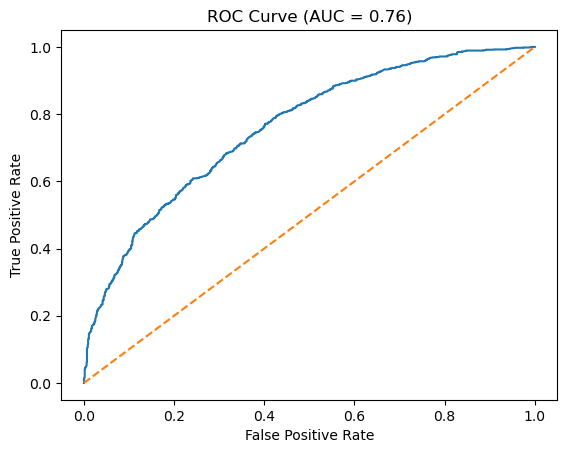

In [ ]:
def main():
    seasons = [Season("2021"), Season("2022"), Season("2023")]
    all_games = []

    # Fetch and build dataset for each season
    for season in seasons:
        team_stats = leaguedashteamstats.LeagueDashTeamStats(
            season=season.formatted_season(), season_type_all_star="Regular Season"
        ).get_data_frames()[0]
        df = prepare_dataset(season, team_stats, additional_columns=ADDL_STATS)
        df = add_days_rest_column(season, df)
        all_games.append(df)

    # Combine seasons
    data = pd.concat(all_games, ignore_index=True)

    # Extract features and labels
    features = generate_nn_labels(ADDL_STATS)
    X = data[features]
    y = data["WIN"].to_numpy()

    # Split into training (first 5000) and test
    training_size = 5000
    X_train, X_test = X.iloc[:training_size], X.iloc[training_size:]
    y_train, y_test = y[:training_size], y[training_size:]

    # Set up and run logistic regression pipeline with grid search
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(solver="liblinear", max_iter=1000))
    ])
    param_grid = {"model__C":[0.1,1,10], "model__penalty":["l2","l1"]}
    grid = GridSearchCV(pipe, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)

    # Output results
    print("Best params:", grid.best_params_)
    print("Train accuracy:", grid.best_score_)
    print("Test accuracy: ", grid.score(X_test, y_test))


    # ROC Curve & AUC
    y_proba = grid.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.show()

if __name__ == "__main__":
    main()